In [5]:
%matplotlib inline

import os, sys
import tensorflow as tf
import skimage.io as io
sys.path.append("/home/lennon.lin/Repository/github/tf-image-segmentation/")
from tf_image_segmentation.utils.pascal_voc import pascal_segmentation_lut
from tf_image_segmentation.utils.cityscape import cityscape_Label

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

#tfrecords_filename = '/home/lennon.lin/Repository/github/tf-image-segmentation/tf_image_segmentation/recipes/pascal_voc/pascal_augmented_train.tfrecords'
tfrecords_filename = '/home/lennon.lin/Repository/github/tf-image-segmentation/tf_image_segmentation/recipes/cityscape/cityscape_trainid_train.tfrecords'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
def get_labels_from_annotation(annotation_tensor, class_labels):
    """Returns tensor of size (width, height, num_classes) derived from annotation tensor.
    The function returns tensor that is of a size (width, height, num_classes) which
    is derived from annotation tensor with sizes (width, height) where value at
    each position represents a class. The functions requires a list with class
    values like [0, 1, 2 ,3] -- they are used to derive labels. Derived values will
    be ordered in the same way as the class numbers were provided in the list. Last
    value in the aforementioned list represents a value that indicate that the pixel
    should be masked out. So, the size of num_classes := len(class_labels) - 1.
    
    Parameters
    ----------
    annotation_tensor : Tensor of size (width, height)
        Tensor with class labels for each element
    class_labels : list of ints
        List that contains the numbers that represent classes. Last
        value in the list should represent the number that was used
        for masking out.
        
    Returns
    -------
    labels_2d_stacked : Tensor of size (width, height, num_classes).
        Tensor with labels for each pixel.
    """

    # Last value in the classes list should show
    # which number was used in the annotation to mask out
    # the ambigious regions or regions that should not be                                                                                                                                                      
    # used for training.
    # TODO: probably replace class_labels list with some custom object
    valid_entries_class_labels = class_labels[:-1]
    
    # Stack the binary masks for each class
    labels_2d = map(lambda x: tf.equal(annotation_tensor, x),
                    valid_entries_class_labels)
    
    # Perform the merging of all of the binary masks into one matrix
    labels_2d_stacked = tf.stack(labels_2d, axis=2)
    print(labels_2d_stacked)
    # Convert tf.bool to tf.float
    # Later on in the labels and logits will be used
    # in tf.softmax_cross_entropy_with_logits() function
    # where they have to be of the float type.
    labels_2d_stacked_float = tf.to_float(labels_2d_stacked)
    return labels_2d_stacked_float
def get_labels_from_annotation_batch(annotation_batch_tensor, class_labels):
    """Returns tensor of size (batch_size, width, height, num_classes) derived
    from annotation batch tensor. The function returns tensor that is of a size
    (batch_size, width, height, num_classes) which is derived from annotation tensor
    with sizes (batch_size, width, height) where value at each position represents a class.
    The functions requires a list with class values like [0, 1, 2 ,3] -- they are
    used to derive labels. Derived values will be ordered in the same way as
    the class numbers were provided in the list. Last value in the aforementioned
    list represents a value that indicate that the pixel should be masked out.
    So, the size of num_classes len(class_labels) - 1.
    
    Parameters
    ----------
    annotation_batch_tensor : Tensor of size (batch_size, width, height)
        Tensor with class labels for each element
    class_labels : list of ints                                                                                                                                                                                
        List that contains the numbers that represent classes. Last
        value in the list should represent the number that was used
        for masking out.
        
    Returns
    -------
    batch_labels : Tensor of size (batch_size, width, height, num_classes).
        Tensor with labels for each batch.
    """

    batch_labels = tf.map_fn(fn=lambda x: get_labels_from_annotation(annotation_tensor=x, class_labels=class_labels),
                             elems=annotation_batch_tensor,
                             dtype=tf.float32)

    return batch_labels

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=1,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
#pascal_voc_lut = pascal_segmentation_lut()

# for ll in cityscape_Label:
#     print('a value',ll[2])
#print(cityscape_lut)
#class_labels = pascal_voc_lut.keys()
class_labels = map(lambda x: x[1] ,filter(lambda x: x[2] != 255 and x[2] != -1 ,cityscape_Label))
print(len(class_labels))
image, annotation = read_and_decode(filename_queue)
labels_batch_tensor = get_labels_from_annotation_batch(annotation_batch_tensor=annotation,
                                                           class_labels=class_labels)
print(annotation)
# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

34
Tensor("map_4/while/stack:0", shape=(384, 384, 33, 1), dtype=bool)
Tensor("shuffle_batch_4:1", shape=(1, 384, 384, 1), dtype=uint8)


(384, 384, 3)
(384, 384)
current batch


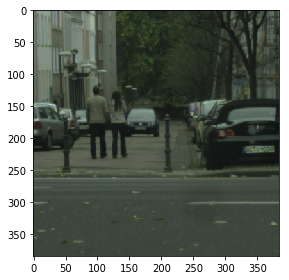

/home/lennon.lin/.pyenv/versions/2.7.12/envs/TensorJupyter2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


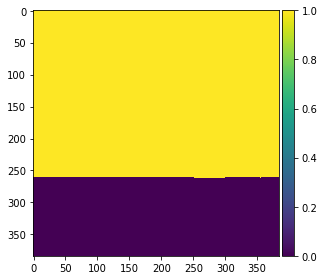

(384, 384, 3)
(384, 384)
current batch


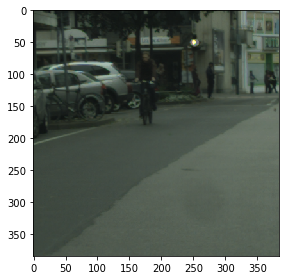

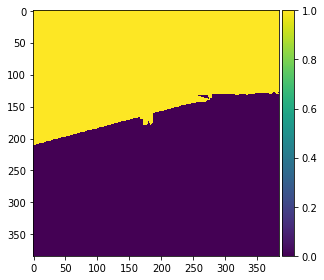

(384, 384, 3)
(384, 384)
current batch


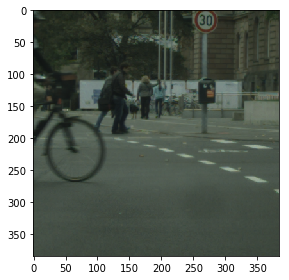

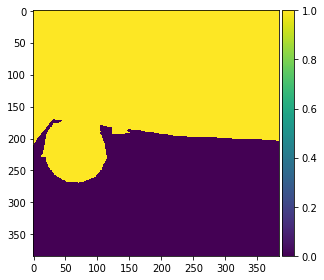

In [2]:
with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0].shape)
        print(anno[0,:,:,0].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

#         io.imshow(img[0, :, :, :])
        io.imshow(img[0])
        io.show()

#         io.imshow(anno[0, :, :, 0])
        io.imshow(anno[0,:,:,0])
        io.show()
        
#         io.imshow(img[1, :, :, :])
#         io.show()

#         io.imshow(anno[1, :, :, 0])
#         io.show()
        
    
    coord.request_stop()
    coord.join(threads)